In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

device: mps


In [2]:
# Preprocess data

edge = torch.load("./Cora/edge.pt")
edge = torch.transpose(edge, 0, 1)

feat = torch.load("./Cora/feat.pt").type(torch.float32)

label = torch.load("./Cora/label.pt")

degree = torch.from_numpy(np.bincount(edge[:, 0]))

feat = feat.to(device)
degree = degree.to(device)
edge = edge.to(device)


print(f"# Nodes: {feat.shape[0]}")
print(f"# Edges: {edge.shape[0]}")

num_nodes, dim_feat = feat.shape
num_label = max(label) + 1
dim_hidden = 128

adj = torch.zeros((num_nodes, num_nodes), device=device)
print(edge)
for i, j in edge:
    adj[i, j] += 1

# Nodes: 2708
# Edges: 10556
tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]], device='mps:0')


In [3]:
# Train/Validation/Test Split
train_ratio = 0.8
valid_ratio = 0.1

train_end = int(train_ratio * num_nodes)
valid_end = train_end + int(valid_ratio * num_nodes)

idx_shuffle = list(range(num_nodes))
random.shuffle(idx_shuffle)

idx_train = idx_shuffle[:train_end]
idx_valid = idx_shuffle[train_end:valid_end]
idx_test = idx_shuffle[valid_end:]

print(f"# Train: {len(idx_train)} ({len(idx_train) / num_nodes * 100:.1f} %)")
print(f"# Valid: {len(idx_valid)} ({len(idx_valid) / num_nodes * 100:.1f} %)")
print(f"# Test: {len(idx_test)} ({len(idx_test) / num_nodes * 100:.1f} %)")

# Train: 2166 (80.0 %)
# Valid: 270 (10.0 %)
# Test: 272 (10.0 %)


In [3]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int, dim_out: int):
        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.act = nn.ReLU()

        self.weight = nn.Parameter(data=torch.zeros((dim_in, dim_out), device=device), requires_grad=False)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, feat: torch.Tensor,
                adjacency: torch.Tensor,
                activate: bool) -> torch.Tensor:
        
        adj_eye = adjacency + torch.eye(num_nodes, device=device)
        degree = torch.sum(adj_eye, dim=1)
        # diag_inv_sqrt = torch.diag(torch.sqrt(1/degree))
        dgr_inv = torch.diag(1/degree)
        
        laplace_sym = dgr_inv @ adj_eye #@ diag_inv_sqrt
        out = laplace_sym @ feat @ self.weight
        if activate:
            out = self.act(out)
        
        return out

In [4]:
class GraphSage(nn.Module):

    def __init__(self, num_layers: int,
                 dim_in: int,
                 dim_hidden: int,
                 dim_out: int):

        super(GraphSage, self).__init__()

        self.num_layers = num_layers
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out

        self.layers = nn.ModuleList()
        for l in range(num_layers):
            self.layers.append(GraphSageLayer(self.dim_in if l == 0 else self.dim_hidden, self.dim_hidden if l < num_layers-1 else self.dim_out))


    def forward(self, feat: torch.Tensor,
                adj: torch.Tensor) -> torch.Tensor:

        x_in = feat
        for layer in self.layers:
            x_out = layer(x_in, adj, (False if self.layers[-1] == layer else True))
            x_in = x_out

        return x_out

In [8]:
from itertools import combinations

def measure_node_smoothness(features: np.ndarray) -> np.ndarray:
    
    def compute_sim(i, j):
        x, y = features[i, :], features[j, :]
        return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        
    compute_sim_vec = np.vectorize(compute_sim)
    
    n = features.shape[0]
    node_comb = combinations(range(n), 2)
    i, j = np.array(list(node_comb)).T
    similarities = compute_sim_vec(i, j)
    # mean_score = np.mean(np.abs(similarities))
    # print(mean_score)
    return np.mean(np.abs(similarities))



In [9]:
LAYERS = list(range(1, 11))

dim_in = feat.shape[1]
dim_hidden = 700
dim_out = 700
SEED = 42

torch.manual_seed(SEED)

node_smoothness_dict = dict()

for num_layer in tqdm(LAYERS):
    model = GraphSage(num_layer, dim_in, dim_hidden, dim_out)
    model.eval()

    feature_matrix = model(feat, adj)
    feature_matrix = feature_matrix.detach().cpu().numpy()
    node_smoothness_dict[num_layer] = measure_node_smoothness(feature_matrix)
    
print(node_smoothness_dict)


100%|██████████| 10/10 [02:05<00:00, 12.54s/it]

{1: 0.15689756, 2: 0.5474486, 3: 0.6654273, 4: 0.75878, 5: 0.8405552, 6: 0.8898172, 7: 0.91136557, 8: 0.92212397, 9: 0.9171471, 10: 0.95404464}


In [11]:
overlap = {1: 0.0020289551, 2: 0.0102909, 3: 0.034722142, 4: 0.10123565, 5: 0.23407511, 6: 0.41416037, 7: 0.58068925, 8: 0.6965425, 9: 0.7644199, 10: 0.80184233}


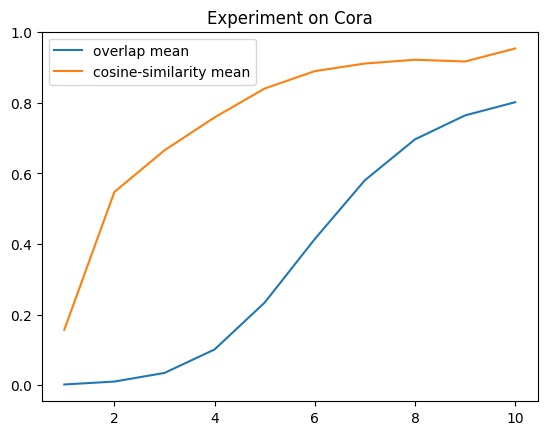

In [14]:
plt.title("Experiment on Cora")
plt.plot(LAYERS, overlap.values(), label="overlap mean")
plt.plot(LAYERS, node_smoothness_dict.values(), label="cosine-similarity mean")
plt.legend()
plt.savefig("cora.png")